# Plot multi-tree model views

To demonstrate how the multi-tree models work, this notebook shows example views of a tree from an origin timepoint and subsequent subtrees added at later timepoints. These views should clarify the following points:

  - topological variation between timepoints
  - width of training and validation time windows
  - clade assignments by timepoint
  - clade linkage between timepoints by traversal


## Imports

In [138]:
from augur.titer_model import TiterCollection
from augur.utils import json_to_tree
import json
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [139]:
sns.set_style("ticks")
plt.style.use("huddlej")

In [140]:
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 14

In [141]:
tip_size = 14

In [142]:
end_date = 2003.0

## Load trees

In [143]:
with open("../results/auspice/flu_h3n2_10_sample_0_1994-10-01_2015-10-01_2001-10-01_ha_tree.json", "r") as fh:
    origin_tree_json = json.load(fh)

In [144]:
origin_tree = json_to_tree(origin_tree_json)

In [145]:
with open("../results/auspice/flu_h3n2_10_sample_0_1994-10-01_2015-10-01_2002-10-01_ha_tree.json", "r") as fh:
    next_tree_json = json.load(fh)

In [146]:
next_tree = json_to_tree(next_tree_json)

## Plot origin tree

In [147]:
def plot_tree(tree, color_by_trait=None, initial_branch_width=5, tip_size=10,
              start_date=None, end_date=None, include_color_bar=False, ax=None, colorbar_ax=None,
              earliest_node_date=None, default_color="#cccccc", override_y_values=None,
              cmap=None):
    """Plot a BioPython Phylo tree in the BALTIC-style.
    """
    # Plot H3N2 tree in BALTIC style from Bio.Phylo tree.
    if override_y_values is None:
        override_y_values = {}
        
    yvalues = [node.yvalue for node in tree.find_clades()]
    y_span = max(yvalues)
    y_unit = y_span / float(len(yvalues))

    # Setup colors.
    if color_by_trait:
        trait_name = color_by_trait
        
        if cmap is None:
            traits = [k.attr[trait_name] for k in tree.find_clades()]
            norm = mpl.colors.Normalize(min(traits), max(traits))
            cmap = mpl.cm.viridis

    #
    # Setup the figure grid.
    #

    if ax is None:
        if include_color_bar:
            fig = plt.figure(figsize=(8, 6), facecolor='w')
            gs = gridspec.GridSpec(2, 1, height_ratios=[14, 1], width_ratios=[1], hspace=0.1, wspace=0.1)
            ax = fig.add_subplot(gs[0])
            colorbar_ax = fig.add_subplot(gs[1])
        else:
            fig = plt.figure(figsize=(8, 4), facecolor='w')
            gs = gridspec.GridSpec(1, 1)
            ax = fig.add_subplot(gs[0])

    L=len([k for k in tree.find_clades() if k.is_terminal()])

    # Setup arrays for tip and internal node coordinates.
    tip_circles_x = []
    tip_circles_y = []
    tip_circles_color = []
    tip_circle_sizes = []
    node_circles_x = []
    node_circles_y = []
    node_circles_color = []
    node_line_widths = []
    node_line_segments = []
    node_line_colors = []
    branch_line_segments = []
    branch_line_widths = []
    branch_line_colors = []
    branch_line_labels = []

    for k in tree.find_clades(): ## iterate over objects in tree
        x=k.attr["num_date"] ## or from x position determined earlier
        
        if earliest_node_date and x < earliest_node_date:
            continue
        
        if k.name in override_y_values:
            y = override_y_values[k.name]
        else:
            y = y_span - k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else

        if k.parent is None:
            xp = None
        else:
            xp=k.parent.attr["num_date"] ## get x position of current object's parent

        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        c = default_color
        if color_by_trait and trait_name in k.attr:
            if isinstance(cmap, dict):
                c = cmap[k.attr[trait_name]]
            else:
                c = cmap(norm(k.attr[trait_name]))

        branchWidth=2
        if k.is_terminal(): ## if leaf...
            s = tip_size ## tip size can be fixed

            tip_circle_sizes.append(s)
            tip_circles_x.append(x)
            tip_circles_y.append(y)
            tip_circles_color.append(c)
        else: ## if node...
            k_leaves = [child
                        for child in k.find_clades()
                        if child.is_terminal()]

            # Scale branch widths by the number of tips.
            branchWidth += initial_branch_width * len(k_leaves) / float(L)

            if len(k.clades)==1:
                node_circles_x.append(x)
                node_circles_y.append(y)
                node_circles_color.append(c)

            ax.plot([x,x],[y_span - k.clades[-1].yvalue, y_span - k.clades[0].yvalue], lw=branchWidth, color=c, ls='-', zorder=9, solid_capstyle='round')

        branch_line_segments.append([(xp, y), (x, y)])
        branch_line_widths.append(branchWidth)
        branch_line_colors.append(c)

    branch_lc = LineCollection(branch_line_segments, zorder=9)
    branch_lc.set_color(branch_line_colors)
    branch_lc.set_linewidth(branch_line_widths)
    branch_lc.set_label(branch_line_labels)
    branch_lc.set_linestyle("-")
    ax.add_collection(branch_lc)

    # Add circles for tips and internal nodes.
    tip_circle_sizes = np.array(tip_circle_sizes)
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath
    ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

    #ax.set_ylim(-10, y_span - 300)

    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])

    if start_date:
        ax.set_xlim(left=start_date)

    if end_date:
        ax.set_xlim(right=end_date)

    if include_color_bar:
        cb1 = mpl.colorbar.ColorbarBase(
            colorbar_ax,
            cmap=cmap,
            norm=norm,
            orientation='horizontal'
        )
        cb1.set_label(color_by_trait)

    return ax, colorbar_ax

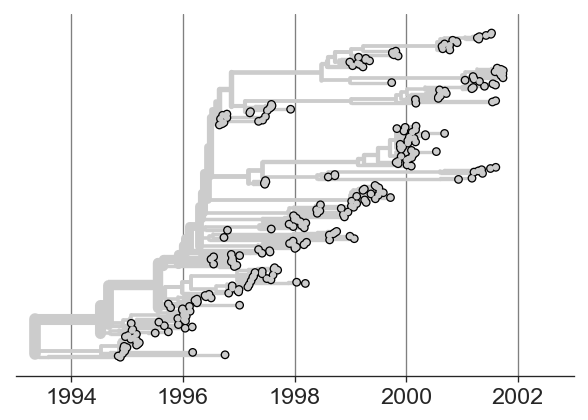

In [148]:
fig = plt.figure(figsize=(6, 4), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])
    
ax, colorbar_ax = plot_tree(origin_tree, ax=ax, start_date=1993.0, end_date=end_date, tip_size=tip_size)
ax.grid(axis='x',ls='-',color='grey')

## Plot next tree

This tree includes samples from the next year since the origin tree.

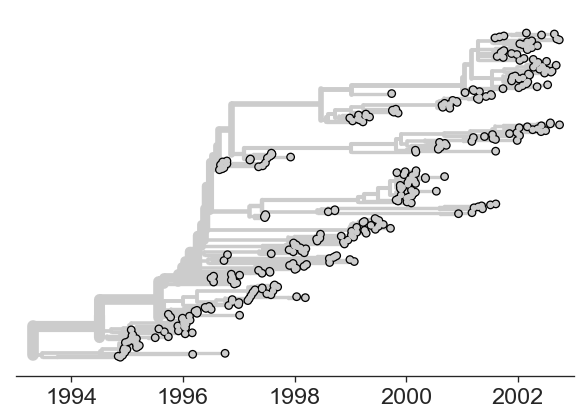

In [149]:
fig = plt.figure(figsize=(6, 4), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])
    
ax, colorbar_ax = plot_tree(next_tree, ax=ax, start_date=1993.0, end_date=end_date, tip_size=tip_size)

## Overlay the two trees

Plot all nodes from both trees.

In [150]:
earliest_node_date = max([node.attr["num_date"] for node in origin_tree.find_clades(terminal=True)])

In [151]:
earliest_node_date

2001.7419575633128

In [152]:
origin_y_values = [node.yvalue for node in origin_tree.find_clades()]
max_origin_y = max(origin_y_values)
override_y_values = {node.name: max_origin_y - node.yvalue for node in origin_tree.find_clades(terminal=True)}

max_next_y = max([node.yvalue for node in next_tree.find_clades()])
max_y = max(max_origin_y, max_next_y)

In [153]:
max_y

333

(-14.990250628182366, 343)

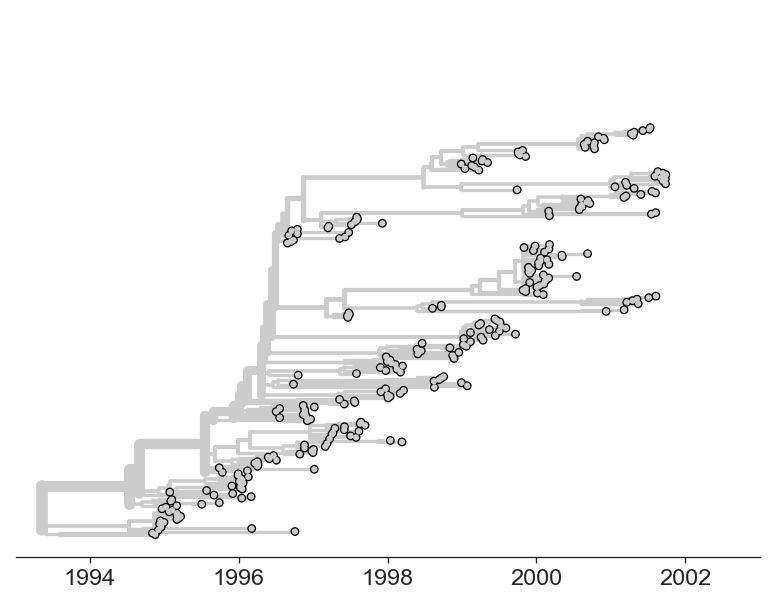

In [214]:
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])
    
ax, colorbar_ax = plot_tree(origin_tree, ax=ax, start_date=1993.0, end_date=end_date, tip_size=tip_size)
ax.set_ylim(top=max_y + 10)

(-14.990250628182366, 343)

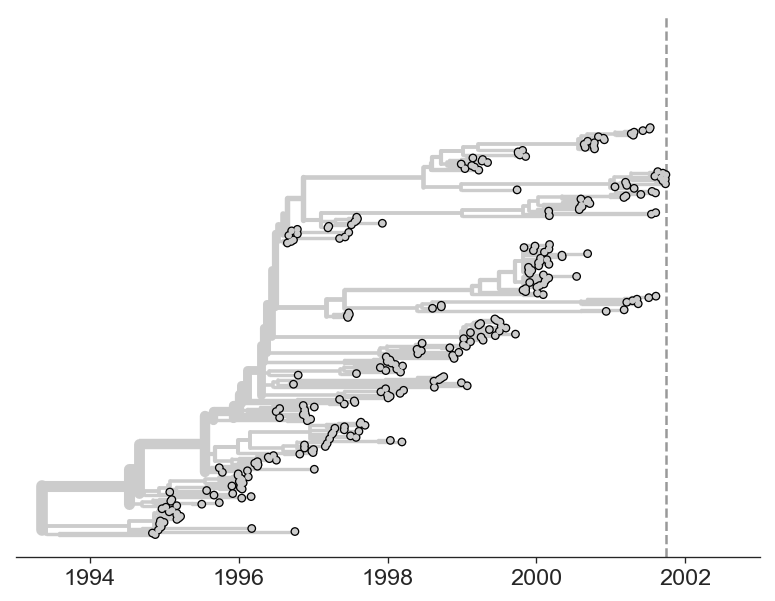

In [155]:
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])
    
ax, colorbar_ax = plot_tree(origin_tree, ax=ax, start_date=1993.0, end_date=end_date, tip_size=tip_size)
ax.axvline(x=earliest_node_date, color="#999999", linestyle="--")
ax.set_ylim(top=max_y + 10)

(-18.571156239273062, 343)

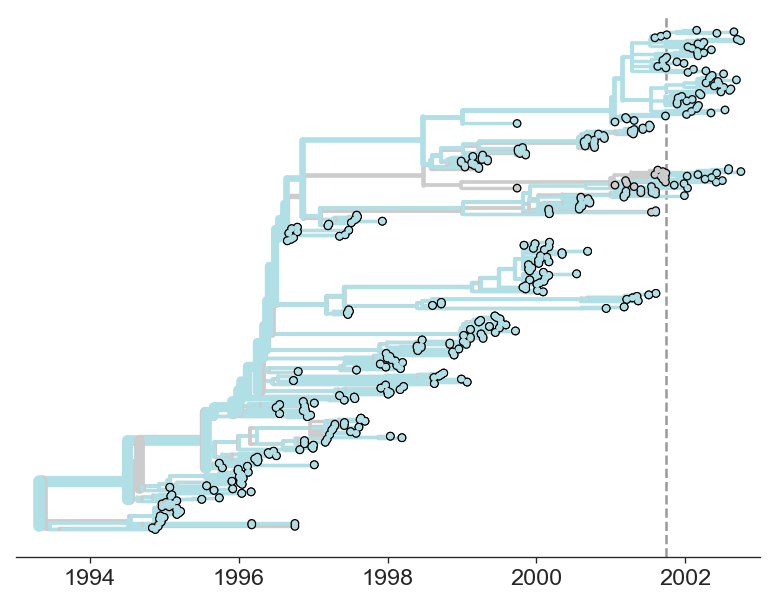

In [156]:
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])
    
ax, colorbar_ax = plot_tree(origin_tree, ax=ax, start_date=1993.0, end_date=end_date, tip_size=tip_size)
ax.axvline(x=earliest_node_date, color="#999999", linestyle="--")

ax, colorbar_ax = plot_tree(
    next_tree,
    ax=ax,
    start_date=1993.0,
    end_date=end_date,
    earliest_node_date=None,
    default_color="powderblue",
    tip_size=tip_size
)

ax.set_ylim(top=max_y + 10)

(-18.571156239273062, 343)

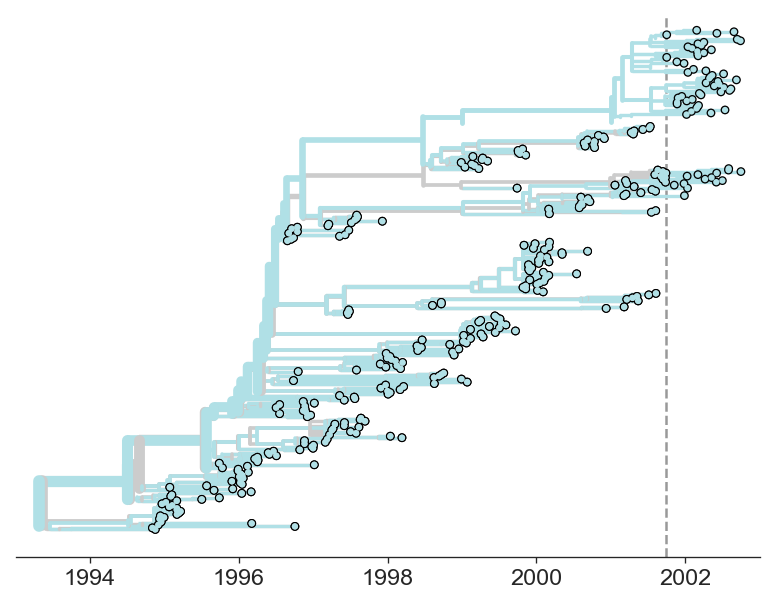

In [157]:
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])
    
ax, colorbar_ax = plot_tree(origin_tree, ax=ax, start_date=1993.0, end_date=end_date, tip_size=tip_size)
ax.axvline(x=earliest_node_date, color="#999999", linestyle="--")

ax, colorbar_ax = plot_tree(
    next_tree,
    ax=ax,
    start_date=1993.0,
    end_date=end_date,
    earliest_node_date=None,
    default_color="powderblue",
    tip_size=tip_size,
    override_y_values=override_y_values
)

ax.set_ylim(top=max_y + 10)

Now plot only nodes from the next tree since the last sample in the origin tree.

(-18.20756451959558, 343)

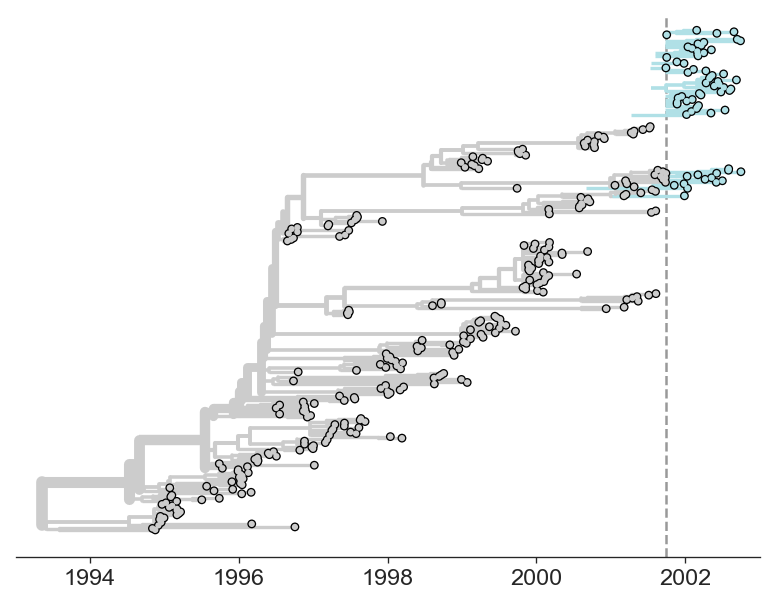

In [158]:
tip_size = 14
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])
    
ax, colorbar_ax = plot_tree(origin_tree, ax=ax, start_date=1993.0, end_date=end_date, tip_size=tip_size)
ax.axvline(x=earliest_node_date, color="#999999", linestyle="--")

ax, colorbar_ax = plot_tree(
    next_tree,
    ax=ax,
    start_date=1993.0,
    end_date=end_date,
    earliest_node_date=earliest_node_date,
    default_color="powderblue",
    tip_size=tip_size
)
ax.set_ylim(top=max_y + 10)

Highlight the training and validation windows.

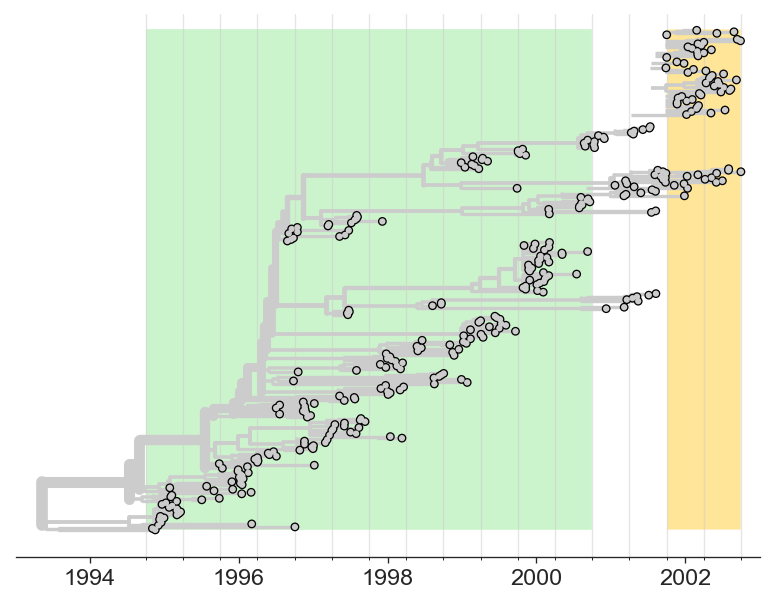

In [159]:
tip_size = 14
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])
    
ax, colorbar_ax = plot_tree(origin_tree, ax=ax, start_date=1993.0, end_date=end_date, tip_size=tip_size)
#ax.axvline(x=earliest_node_date, color="#999999", linestyle="--")

ax, colorbar_ax = plot_tree(
    next_tree,
    ax=ax,
    start_date=1993.0,
    end_date=end_date,
    earliest_node_date=earliest_node_date,
    tip_size=tip_size
)
ax.set_ylim(top=max_y + 10)

# Highlight training window.
rectangle = plt.Rectangle((1994.75, 0), 6.0, max_y, fc='#00cc00',
                          alpha=0.2, zorder=-10)
ax.add_patch(rectangle)

# Highlight validation window.
rectangle = plt.Rectangle((2001.75, 0), 1.0, max_y, fc='#ffcc33',
                          alpha=0.5, zorder=-10)
ax.add_patch(rectangle)

ax.set_xticks(np.arange(1994.75, 2003.25, 0.5), minor=True)

ax.grid(
    axis='x',
    ls='-',
    color='#cccccc',
    alpha=0.5,
    which="minor"
)

In [160]:
origin_tips = {tip.name: tip.attr["num_date"] for tip in origin_tree.find_clades(terminal=True)}
next_tips = {tip.name: tip.attr["num_date"] for tip in next_tree.find_clades(terminal=True)}

In [161]:
len(next_tips)

333

In [162]:
len(origin_tips)

269

In [163]:
earliest_node_date

2001.7419575633128

In [164]:
[(tip, date) for tip, date in next_tips.items() if tip not in origin_tips and date <= earliest_node_date]

[]

In [165]:
for tip in [tip for tip, date in next_tips.items() if tip not in origin_tips and date <= earliest_node_date]:
    print(tip)

In [166]:
clades = set()
for node in origin_tree.find_clades():
    clades.add(node.attr["clade_membership"])

for node in next_tree.find_clades():
    if node.attr["num_date"] > earliest_node_date:
        clades.add(node.attr["clade_membership"])

In [167]:
len(clades)

37

In [197]:
cmap = plt.get_cmap("tab20")

In [198]:
color_by_clade = {clade: cmap(i % 20) for i, clade in enumerate(clades)}

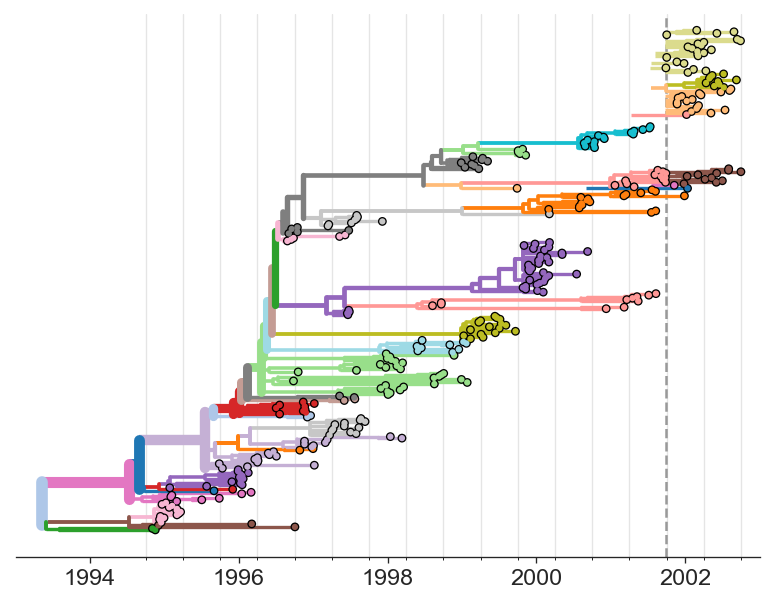

In [199]:
tip_size = 14
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])
    
ax, colorbar_ax = plot_tree(
    origin_tree,
    ax=ax,
    start_date=1993.0,
    end_date=end_date,
    tip_size=tip_size,
    color_by_trait="clade_membership",
    cmap=color_by_clade,
    default_color="#ffffff"
)
ax.axvline(x=earliest_node_date, color="#999999", linestyle="--")

ax, colorbar_ax = plot_tree(
    next_tree,
    ax=ax,
    start_date=1993.0,
    end_date=end_date,
    earliest_node_date=earliest_node_date,
    tip_size=tip_size,
    color_by_trait="clade_membership",
    cmap=color_by_clade,
    default_color="#ffffff"
)
ax.set_ylim(top=max_y + 10)

ax.set_xticks(np.arange(1994.75, 2003.25, 0.5), minor=True)

ax.grid(
    axis='x',
    ls='-',
    color='#cccccc',
    alpha=0.5,
    which="minor"
)

In [200]:
final_tips_by_clades = pd.read_table("../results/builds/h3n2/10_viruses_per_month/sample_0/1994-10-01--2015-10-01/final_clade_frequencies.tsv")

In [201]:
final_tips_by_clades.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,1996-10-01,02e323e,1997-10-01,A/Auckland/10/1997,0.035959
1,1996-10-01,02e323e,1997-10-01,A/HongKong/CUHK12160/1997,0.033047
2,1996-10-01,02e323e,1997-10-01,A/HongKong/CUHK12563/1997,0.036006
3,1996-10-01,02e323e,1997-10-01,A/HongKong/CUHK12626/1997,0.036066
4,1996-10-01,02e323e,1997-10-01,A/HongKong/CUHK20236/1997,0.036691


In [202]:
tips_to_previous_clades = dict(
    final_tips_by_clades.loc[final_tips_by_clades["initial_timepoint"] == "2001-10-01", ["strain", "clade_membership"]].values
)

In [203]:
for tip in next_tree.find_clades(terminal=True):
    if tip.name in tips_to_previous_clades:
        tip.attr["previous_clade_membership"] = tips_to_previous_clades[tip.name]
    elif tip.attr["num_date"] > earliest_node_date:
        print(tip)

A/HongKong/CUHK50080/2001
A/HongKong/CUHK50200/2002
A/NewYork/55/2001
A/NewYork/71/2001
A/NewYork/401/2001
A/WesternAustralia/17/2001
A/Auckland/603/2001


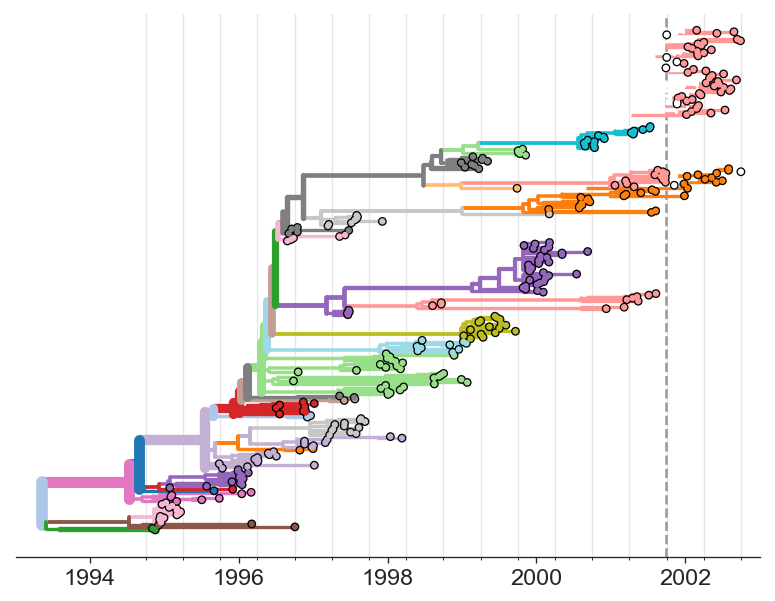

In [208]:
tip_size = 14
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])
    
ax, colorbar_ax = plot_tree(
    origin_tree,
    ax=ax,
    start_date=1993.0,
    end_date=end_date,
    tip_size=tip_size,
    color_by_trait="clade_membership",
    cmap=color_by_clade,
    default_color="#ffffff"
)
ax.axvline(x=earliest_node_date, color="#999999", linestyle="--")

ax, colorbar_ax = plot_tree(
    next_tree,
    ax=ax,
    start_date=1993.0,
    end_date=end_date,
    earliest_node_date=earliest_node_date,
    tip_size=tip_size,
    color_by_trait="previous_clade_membership",
    cmap=color_by_clade,
    default_color="#ffffff"
    #override_y_values=override_y_values
)
ax.set_ylim(top=max_y + 10)

ax.set_xticks(np.arange(1994.75, 2003.25, 0.5), minor=True)

ax.grid(
    axis='x',
    ls='-',
    color='#cccccc',
    alpha=0.5,
    which="minor"
)

In [205]:
tips_to_clades.head()

,tip,clade_membership,depth,lineage,segment,timepoint
0,A/NewYork/657/1994,726b03c,0,h3n2,ha,1996-10-01
1,A/NewYork/657/1994,f8b9dde,2,h3n2,ha,1996-10-01
2,A/NewYork/657/1994,root,3,h3n2,ha,1996-10-01
3,A/HongKong/42/1996,34f68f9,0,h3n2,ha,1996-10-01
4,A/HongKong/42/1996,726b03c,1,h3n2,ha,1996-10-01


In [206]:
tips_to_clades[(tips_to_clades["tip"] == "A/Auckland/603/2001") & (tips_to_clades["timepoint"] == "2002-10-01")]

,tip,clade_membership,depth,lineage,segment,timepoint
21284,A/Auckland/603/2001,fbbd597,0,h3n2,ha,2002-10-01
21285,A/Auckland/603/2001,5bed3da,7,h3n2,ha,2002-10-01
21286,A/Auckland/603/2001,05a6dc1,8,h3n2,ha,2002-10-01
21287,A/Auckland/603/2001,f39e6da,10,h3n2,ha,2002-10-01
21288,A/Auckland/603/2001,048f8ca,11,h3n2,ha,2002-10-01
21289,A/Auckland/603/2001,e64cc68,15,h3n2,ha,2002-10-01
21290,A/Auckland/603/2001,e2f3876,16,h3n2,ha,2002-10-01
21291,A/Auckland/603/2001,d6906cf,17,h3n2,ha,2002-10-01
21292,A/Auckland/603/2001,88dab64,18,h3n2,ha,2002-10-01
21293,A/Auckland/603/2001,98c068a,19,h3n2,ha,2002-10-01


In [210]:
tips_to_clades[(tips_to_clades["clade_membership"] == "fbbd597") & (tips_to_clades["timepoint"] == "2001-10-01")]

,tip,clade_membership,depth,lineage,segment,timepoint
14117,A/WesternAustralia/15/2001,fbbd597,2,h3n2,ha,2001-10-01
14135,A/WesternAustralia/16/2001,fbbd597,2,h3n2,ha,2001-10-01
14152,A/Queensland/14/2001,fbbd597,0,h3n2,ha,2001-10-01
14169,A/Queensland/20/2001,fbbd597,0,h3n2,ha,2001-10-01
14187,A/Auckland/604/2001,fbbd597,2,h3n2,ha,2001-10-01
14205,A/Waikato/105/2001,fbbd597,2,h3n2,ha,2001-10-01
14223,A/Auckland/602/2001,fbbd597,2,h3n2,ha,2001-10-01


In [213]:
"fbbd597" in clades

True

## Plot a subtree to demonstrate predictors

In [222]:
subtree = None
potential_subtrees = [node for node in origin_tree.find_clades(terminal=False)
                      if node.count_terminals() == 5]

In [223]:
len(potential_subtrees)

15

In [225]:
subtree = potential_subtrees[2]

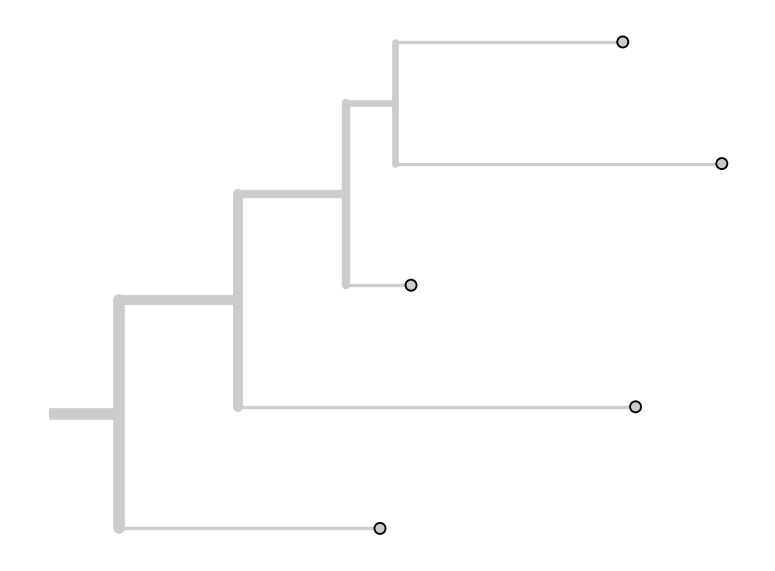

In [235]:
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = gridspec.GridSpec(1, 1, height_ratios=[1], width_ratios=[1], hspace=0.1, wspace=0.1)
ax = fig.add_subplot(gs[0])

ax, colorbar_ax = plot_tree(subtree, tip_size=30, initial_branch_width=5, ax=ax)
ax.set_xticks([])
ax.spines['bottom'].set_visible(False)

## Math equations for predictors

Delta frequency:

$$\frac{\Delta{x}}{\Delta{t}}$$

Information gain:

$$
\sum_{v \in K(t)}{Y_{v}(t + 1) \log{\frac{\hat{Y}_{v}(t + 1)}{Y_v{}(t)}}}
$$

The epitope cross-immunity predictor is defined as follows:

$$
f_{i}^{ep\_x} = f_{0} - \sigma_{ep\_x} \sum_{j:t_{j} < t_{i}}{x_{j}c(D_{ep}(a_{i}, a_{j}))}
$$

where $\sigma_{ep}$ is a parameter learned from data.

The function $c(D_{ep})$ is defined as follows:

$$
c(D_{ep}) = \exp(-D_{ep} / D_{0})
$$


### Hamming distance

Weighted Hamming distance between viruses a and m:

$$
(x_{a}\exp{(f_{a}\Delta{t})})(x_{m})(d_{am})
$$

General weighted Hamming distance between virus a and all other future viruses:

$$
H_{a} = x_{m}d_{am} + x_{n}d_{an} + x_{o}d_{ao}
$$

Then the overall weighted Hamming distance between all viruses at time t and t + 1 is given by:

$$
H(t) = H_{a}x_{a}\exp{(f_{a}\Delta{t})} + H_{b}x_{b}\exp{(f_{b}\Delta{t})} + H_{c}x_{c}\exp{(f_{c}\Delta{t})}
$$

Actually, I think there is a problem with the above logic since there is not an estimator for the future Hamming distance but only a calculation of observed Hamming distance.

The observed weighted Hamming distance between virus a and all viruses in the next year would be:

$$
\begin{align}
H_{a}(t + 1) = x_{a}(t)(x_{m}(t + 1)d_{am} + \\
                        x_{n}(t + 1)d_{an} + \\
                        x_{o}(t + 1)d_{ao})
\end{align}
$$

The estimated weighted Hamming distance when forecasting cannot include distances from future sequences. Instead, I think we need to estimate the composition of the future timepoint by projecting the current viruses forward by their fitnesses. The estimated distance is then between current and projected frequencies of viruses at the current timepoint.

$$
\begin{align}
\hat{H}_{a}(t + 1) = x_{a}(t)(x_{a}(t)\exp{(f_{a}\Delta{t})}d_{aa} + \\
                              x_{b}(t)\exp{(f_{b}\Delta{t})}d_{ab} + \\
                              x_{c}(t)\exp{(f_{c}\Delta{t})}d_{ac})
\end{align}
$$

Or, a more computationally efficient approach for optimization would be:

$$
\begin{align}
\hat{H}(t + 1) = x_{a}(t)\exp{(f_{a}\Delta{t})}(x_{b}(t)d_{ba} + x_{c}(t)d_{ca}) + \\
                 x_{b}(t)\exp{(f_{b}\Delta{t})}(x_{a}(t)d_{ab} + x_{c}(t)d_{cb}) + \\
                 x_{c}(t)\exp{(f_{c}\Delta{t})}(x_{a}(t)d_{ac} + x_{b}(t)d_{bc})
\end{align}
$$